In [1]:
import numpy as np
import pandas as pd
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import math
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import adabound
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler, RobustScaler

torch.cuda.is_available()

False

In [14]:
mydata = pd.read_csv('D:/Cho Lab Dropbox/연구과제별정리/02 목적과제_SPPEC_암종별(임상)_상희회준/위암/03 머신러닝_회준종혁다혜/01 Model/다혜/DL_data_2211.csv')

In [15]:
mydata = mydata[mydata['Age']>64]

In [16]:
event_data = mydata['Clavien_Dindo']
pd.crosstab(mydata['OP_year'], mydata['Clavien_Dindo'])

Clavien_Dindo,0,1,2
OP_year,,,
2014,170,23,22
2015,145,16,9
2016,146,25,18
2017,133,27,26
2018,122,19,15
2019,125,6,15
2020,115,34,20
2021,100,51,21


In [21]:
x_dat = mydata[[ 
        'Age',
        'Platelets',
        'Albumin',
        'Cell_Count',
        'WBC',
        'Hemoglobin',
        'Segmented_neutrophil',
        'ANC',
        'Lymphocytes',
        'NLR',
        'PNI',
        'SII',
        'OP_time',
        'EBL',
    
        'Hemoglobin_status',
        'Neutrophil_count_status',
        'Sex',
        'ASA_Score',
        'Smoking',
        'Drinking',
        'BMI',
        'Hypertension',
        'Diabetes',
        'Ass_condition_grp',
        'Ass_lesion',
        'Clinical_Stage',
        'Histology',
        'Lauren',
        'Reconstruction',
        'Combined_Resection',
        
                     'fStage',
                'Location',
                'LN_Dissection',
                'Operation',
                'Intraop_cc'
              
               ]]

In [22]:
nsubject = mydata.shape[0]

In [23]:
contvar = ['Age', "Platelets", "Albumin", "Cell_Count", 'WBC',
        'Hemoglobin',
        'Segmented_neutrophil',
        'ANC',
        'Lymphocytes',
        'NLR',
        'PNI',
        'SII',
          'OP_time', 
           'EBL']
catevar= x_dat.columns[[x not in contvar for x in x_dat.columns]]


In [24]:
x_dat2 = x_dat.copy()
x_dat2[catevar] = x_dat2[catevar].astype("category")

print(x_dat2.dtypes)

Age                           int64
Platelets                     int64
Albumin                     float64
Cell_Count                  float64
WBC                         float64
Hemoglobin                  float64
Segmented_neutrophil        float64
ANC                           int64
Lymphocytes                 float64
NLR                         float64
PNI                         float64
SII                           int64
OP_time                       int64
EBL                         float64
Hemoglobin_status          category
Neutrophil_count_status    category
Sex                        category
ASA_Score                  category
Smoking                    category
Drinking                   category
BMI                        category
Hypertension               category
Diabetes                   category
Ass_condition_grp          category
Ass_lesion                 category
Clinical_Stage             category
Histology                  category
Lauren                     c

In [25]:
x_dat3.isnull().sum()

Age                  0
Platelets            0
Albumin              0
Cell_Count           0
WBC                  0
                    ..
LN_Dissection_1.0    0
Operation_0          0
Operation_1          0
Intraop_cc_0         0
Intraop_cc_1         0
Length: 73, dtype: int64

In [26]:
x_dat3 = pd.get_dummies(x_dat2, columns=catevar)
X_dat = x_dat3.to_numpy()

In [27]:
X_dat.shape

(1403, 73)

In [28]:
OP_year = mydata['OP_year']
#testindex = np.isin(OP_year, [2020, 2021])
testindex = np.isin(OP_year, [2015, 2017, 2019, 2021])

In [29]:
X_train = X_dat[np.invert(testindex)].copy()
event_train = event_data.values[np.invert(testindex)].copy()

X_test = X_dat[testindex].copy()
event_test = event_data.values[testindex].copy()

ntrain = X_train.shape[0]
nsubject, ntrain, nsubject-ntrain

(1403, 729, 674)

In [34]:
continuous_train=X_train[:, 0:14]
continuous_test=X_test[:, 0:14]

In [35]:
cont_train_RobustScaler = RobustScaler().fit_transform(continuous_train)
stdX_train = X_train.copy()
stdX_train[:, 0:14]=cont_train_RobustScaler

In [37]:
cont_test_RobustScaler = RobustScaler().fit_transform(continuous_test)
stdX_test = X_test.copy()
stdX_test[:, 0:14]=cont_test_RobustScaler

In [38]:
num_event = 2
batch_size = 256
hidden_size = 256

train_data = []
for i in range(ntrain):
    train_data.append([stdX_train[i], event_train[i]])
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, pin_memory=True)
train_loader

In [39]:
cuda = torch.cuda.is_available() # False
if cuda:
    device = 'cuda:0'
else:
    device = 'cpu'

In [40]:
class MLP(nn.Module):
    
    def __init__(self, input_size, hidden_size=128, num_layer=1, num_event=2):
        super(MLP, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layer = num_layer
        self.num_event = num_event
        
        self.hidden_in = nn.Linear(self.input_size, self.hidden_size)
        hiddens = [
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.LeakyReLU(inplace=True),
        ]
        self.hiddens = nn.Sequential(*((num_layer-1)*hiddens))
        self.hidden_out = nn.Linear(self.hidden_size, self.num_event+1)
        self.activation = nn.LeakyReLU(inplace=True)
                
    def forward(self, x):
        ## x: (batch, input_size)

        batch_size = x.shape[0]
        x = self.hidden_in(x)
        x = self.hiddens(self.activation(x))
        x = self.hidden_out(x)
        
        return x

In [ ]:
std_train.shape[-1]

In [41]:
model = MLP(input_size=73, hidden_size=32, num_layer=2, num_event=num_event).to(device)
model

MLP(
  (hidden_in): Linear(in_features=73, out_features=32, bias=True)
  (hiddens): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
  )
  (hidden_out): Linear(in_features=32, out_features=3, bias=True)
  (activation): LeakyReLU(negative_slope=0.01, inplace=True)
)

Drive/01 Research work/gastric_comp/models/65+/MultiMLP_16hiddensize_1layers_1e-03
Epoch: 0, Loss: 9.9599e-02
Epoch: 100, Loss: 8.7777e-02
Epoch: 200, Loss: 8.8280e-02
Epoch: 300, Loss: 8.9835e-02
Epoch: 400, Loss: 8.7631e-02
Epoch: 500, Loss: 9.2449e-02
Epoch: 600, Loss: 8.9214e-02
Epoch: 700, Loss: 9.0133e-02
Epoch: 800, Loss: 8.9908e-02
Epoch: 900, Loss: 8.8706e-02
Epoch: 1000, Loss: 8.9796e-02
Epoch: 1100, Loss: 8.9666e-02


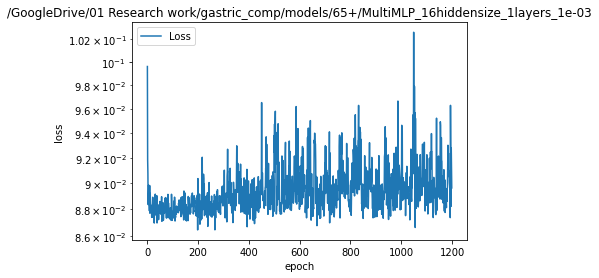

Drive/01 Research work/gastric_comp/models/65+/MultiMLP_16hiddensize_1layers_1e-03
-----------------------------------------------------------------------------
Train accuracy = 0.9835, Test accuracy = 0.6187
Train precision = 0.9837, Test precision = 0.6256
Train recall = 0.9835, Test recall = 0.6187
Train F1 score = 0.9834, Test F1 score = 0.6221
-------------------------------------------------------
Event: Mild; Train AUC = 0.9985, Test AUC = 0.5668
Event: Severe, death; Train AUC = 0.9998, Test AUC = 0.4334
Drive/01 Research work/gastric_comp/models/65+/MultiMLP_16hiddensize_2layers_1e-03
Epoch: 0, Loss: 4.1286e-02
Epoch: 100, Loss: 3.1034e-02
Epoch: 200, Loss: 3.1424e-02
Epoch: 300, Loss: 3.1640e-02
Epoch: 400, Loss: 3.2220e-02
Epoch: 500, Loss: 3.5388e-02
Epoch: 600, Loss: 3.3700e-02
Epoch: 700, Loss: 3.2812e-02
Epoch: 800, Loss: 3.5384e-02
Epoch: 900, Loss: 3.7714e-02
Epoch: 1000, Loss: 3.4217e-02


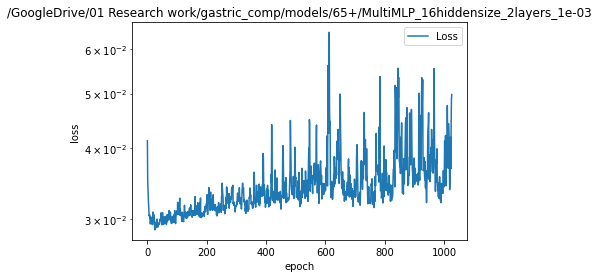

Drive/01 Research work/gastric_comp/models/65+/MultiMLP_16hiddensize_2layers_1e-03
-----------------------------------------------------------------------------
Train accuracy = 0.9945, Test accuracy = 0.5890
Train precision = 0.9945, Test precision = 0.5990
Train recall = 0.9945, Test recall = 0.5890
Train F1 score = 0.9944, Test F1 score = 0.5939
-------------------------------------------------------
Event: Mild; Train AUC = 1.0000, Test AUC = 0.5057
Event: Severe, death; Train AUC = 1.0000, Test AUC = 0.4416
Drive/01 Research work/gastric_comp/models/65+/MultiMLP_32hiddensize_1layers_1e-03
Epoch: 0, Loss: 1.5092e-01
Epoch: 100, Loss: 1.4397e-01
Epoch: 200, Loss: 1.4241e-01
Epoch: 300, Loss: 1.4087e-01
Epoch: 400, Loss: 1.4064e-01
Epoch: 500, Loss: 1.3945e-01
Epoch: 600, Loss: 1.4072e-01
Epoch: 700, Loss: 1.3732e-01
Epoch: 800, Loss: 1.3933e-01
Epoch: 900, Loss: 1.3524e-01
Epoch: 1000, Loss: 1.3749e-01
Epoch: 1100, Loss: 1.3364e-01
Epoch: 1200, Loss: 1.3466e-01
Epoch: 1300, Loss: 1.

Epoch: 24400, Loss: 7.6138e-02
Epoch: 24500, Loss: 7.3713e-02
Epoch: 24600, Loss: 7.8626e-02
Epoch: 24700, Loss: 7.7813e-02
Epoch: 24800, Loss: 7.6216e-02
Epoch: 24900, Loss: 7.4280e-02
Epoch: 25000, Loss: 7.6803e-02
Epoch: 25100, Loss: 7.2334e-02
Epoch: 25200, Loss: 7.8439e-02
Epoch: 25300, Loss: 7.3026e-02
Epoch: 25400, Loss: 7.3682e-02
Epoch: 25500, Loss: 7.4106e-02
Epoch: 25600, Loss: 7.6130e-02
Epoch: 25700, Loss: 7.6583e-02
Epoch: 25800, Loss: 7.3807e-02
Epoch: 25900, Loss: 7.2298e-02
Epoch: 26000, Loss: 7.0994e-02
Epoch: 26100, Loss: 7.0919e-02
Epoch: 26200, Loss: 7.6407e-02
Epoch: 26300, Loss: 7.1542e-02
Epoch: 26400, Loss: 7.3095e-02
Epoch: 26500, Loss: 7.4467e-02
Epoch: 26600, Loss: 7.1997e-02
Epoch: 26700, Loss: 7.4861e-02
Epoch: 26800, Loss: 7.1506e-02
Epoch: 26900, Loss: 7.1488e-02
Epoch: 27000, Loss: 7.4889e-02
Epoch: 27100, Loss: 7.1456e-02
Epoch: 27200, Loss: 6.7857e-02
Epoch: 27300, Loss: 6.9058e-02
Epoch: 27400, Loss: 6.9367e-02
Epoch: 27500, Loss: 6.9265e-02
Epoch: 2

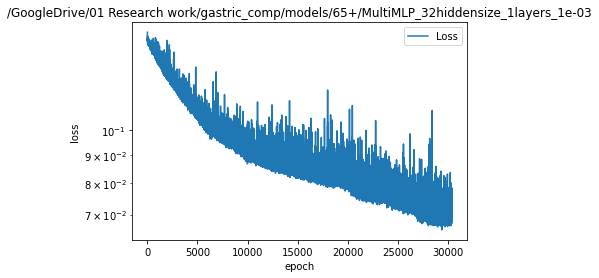

Drive/01 Research work/gastric_comp/models/65+/MultiMLP_32hiddensize_1layers_1e-03
-----------------------------------------------------------------------------
Train accuracy = 0.9973, Test accuracy = 0.6306
Train precision = 0.9973, Test precision = 0.6213
Train recall = 0.9973, Test recall = 0.6306
Train F1 score = 0.9973, Test F1 score = 0.6258
-------------------------------------------------------
Event: Mild; Train AUC = 1.0000, Test AUC = 0.5763
Event: Severe, death; Train AUC = 1.0000, Test AUC = 0.4576
Drive/01 Research work/gastric_comp/models/65+/MultiMLP_32hiddensize_2layers_1e-03
Epoch: 0, Loss: 5.1254e-01
Epoch: 100, Loss: 4.4755e-01
Epoch: 200, Loss: 4.0556e-01
Epoch: 300, Loss: 3.7369e-01
Epoch: 400, Loss: 3.3623e-01
Epoch: 500, Loss: 3.1113e-01
Epoch: 600, Loss: 2.9226e-01
Epoch: 700, Loss: 2.6754e-01
Epoch: 800, Loss: 2.4725e-01
Epoch: 900, Loss: 2.3408e-01
Epoch: 1000, Loss: 2.2550e-01
Epoch: 1100, Loss: 2.1643e-01
Epoch: 1200, Loss: 2.0793e-01
Epoch: 1300, Loss: 2.

Epoch: 24400, Loss: 6.9485e-02
Epoch: 24500, Loss: 8.7982e-02
Epoch: 24600, Loss: 6.8097e-02
Epoch: 24700, Loss: 7.5621e-02
Epoch: 24800, Loss: 7.0903e-02
Epoch: 24900, Loss: 6.3542e-02
Epoch: 25000, Loss: 6.7374e-02
Epoch: 25100, Loss: 7.0201e-02
Epoch: 25200, Loss: 6.7816e-02
Epoch: 25300, Loss: 7.2966e-02
Epoch: 25400, Loss: 6.4998e-02
Epoch: 25500, Loss: 6.3758e-02
Epoch: 25600, Loss: 7.6171e-02
Epoch: 25700, Loss: 8.5934e-02
Epoch: 25800, Loss: 6.8923e-02
Epoch: 25900, Loss: 6.7286e-02
Epoch: 26000, Loss: 7.7386e-02
Epoch: 26100, Loss: 8.8292e-02
Epoch: 26200, Loss: 7.1047e-02
Epoch: 26300, Loss: 6.9076e-02
Epoch: 26400, Loss: 8.9953e-02
Epoch: 26500, Loss: 7.4679e-02
Epoch: 26600, Loss: 1.0295e-01
Epoch: 26700, Loss: 7.4659e-02
Epoch: 26800, Loss: 1.0080e-01
Epoch: 26900, Loss: 6.3967e-02
Epoch: 27000, Loss: 7.5522e-02
Epoch: 27100, Loss: 8.4328e-02
Epoch: 27200, Loss: 8.2091e-02
Epoch: 27300, Loss: 6.5743e-02
Epoch: 27400, Loss: 6.9143e-02
Epoch: 27500, Loss: 7.1925e-02


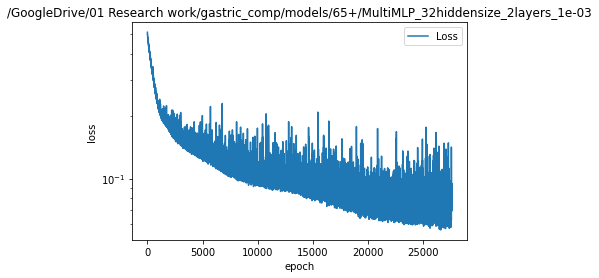

Drive/01 Research work/gastric_comp/models/65+/MultiMLP_32hiddensize_2layers_1e-03
-----------------------------------------------------------------------------
Train accuracy = 0.9835, Test accuracy = 0.5816
Train precision = 0.9836, Test precision = 0.5971
Train recall = 0.9835, Test recall = 0.5816
Train F1 score = 0.9835, Test F1 score = 0.5887
-------------------------------------------------------
Event: Mild; Train AUC = 0.9981, Test AUC = 0.5358
Event: Severe, death; Train AUC = 0.9987, Test AUC = 0.4562
Drive/01 Research work/gastric_comp/models/65+/MultiMLP_64hiddensize_1layers_1e-03
Epoch: 0, Loss: 1.0674e+00
Epoch: 100, Loss: 6.4378e-01
Epoch: 200, Loss: 5.9221e-01
Epoch: 300, Loss: 5.3399e-01
Epoch: 400, Loss: 4.8255e-01
Epoch: 500, Loss: 4.3822e-01
Epoch: 600, Loss: 3.9069e-01
Epoch: 700, Loss: 3.5469e-01
Epoch: 800, Loss: 3.1998e-01
Epoch: 900, Loss: 2.9292e-01
Epoch: 1000, Loss: 2.6977e-01
Epoch: 1100, Loss: 2.4768e-01
Epoch: 1200, Loss: 2.2732e-01
Epoch: 1300, Loss: 2.

Epoch: 24400, Loss: 5.3259e-02
Epoch: 24500, Loss: 5.2391e-02
Epoch: 24600, Loss: 5.2679e-02
Epoch: 24700, Loss: 5.3186e-02
Epoch: 24800, Loss: 5.1984e-02
Epoch: 24900, Loss: 5.3072e-02
Epoch: 25000, Loss: 5.2270e-02
Epoch: 25100, Loss: 5.1889e-02
Epoch: 25200, Loss: 5.2954e-02
Epoch: 25300, Loss: 5.1975e-02
Epoch: 25400, Loss: 5.2319e-02
Epoch: 25500, Loss: 5.2398e-02
Epoch: 25600, Loss: 5.2698e-02
Epoch: 25700, Loss: 5.1640e-02
Epoch: 25800, Loss: 5.1930e-02
Epoch: 25900, Loss: 5.1344e-02
Epoch: 26000, Loss: 5.1890e-02
Epoch: 26100, Loss: 5.1811e-02
Epoch: 26200, Loss: 5.1970e-02
Epoch: 26300, Loss: 5.2031e-02
Epoch: 26400, Loss: 5.1462e-02
Epoch: 26500, Loss: 5.2194e-02
Epoch: 26600, Loss: 5.1748e-02
Epoch: 26700, Loss: 5.1579e-02
Epoch: 26800, Loss: 5.1833e-02
Epoch: 26900, Loss: 5.1703e-02
Epoch: 27000, Loss: 5.1941e-02
Epoch: 27100, Loss: 5.1998e-02
Epoch: 27200, Loss: 5.2317e-02
Epoch: 27300, Loss: 5.3192e-02
Epoch: 27400, Loss: 5.2157e-02
Epoch: 27500, Loss: 5.1229e-02
Epoch: 2

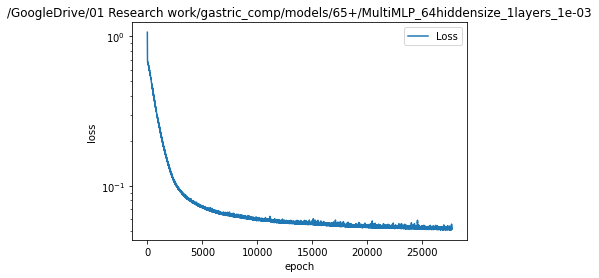

Drive/01 Research work/gastric_comp/models/65+/MultiMLP_64hiddensize_1layers_1e-03
-----------------------------------------------------------------------------
Train accuracy = 1.0000, Test accuracy = 0.6231
Train precision = 1.0000, Test precision = 0.6071
Train recall = 1.0000, Test recall = 0.6231
Train F1 score = 1.0000, Test F1 score = 0.6148
-------------------------------------------------------
Event: Mild; Train AUC = 1.0000, Test AUC = 0.5416
Event: Severe, death; Train AUC = 1.0000, Test AUC = 0.4755
Drive/01 Research work/gastric_comp/models/65+/MultiMLP_64hiddensize_2layers_1e-03
Epoch: 0, Loss: 1.0991e+00
Epoch: 100, Loss: 6.6710e-01
Epoch: 200, Loss: 6.4172e-01
Epoch: 300, Loss: 6.1965e-01
Epoch: 400, Loss: 5.7631e-01
Epoch: 500, Loss: 5.1137e-01
Epoch: 600, Loss: 4.3759e-01
Epoch: 700, Loss: 3.4778e-01
Epoch: 800, Loss: 2.8552e-01
Epoch: 900, Loss: 2.3942e-01
Epoch: 1000, Loss: 1.9291e-01
Epoch: 1100, Loss: 1.6063e-01
Epoch: 1200, Loss: 1.3631e-01
Epoch: 1300, Loss: 1.

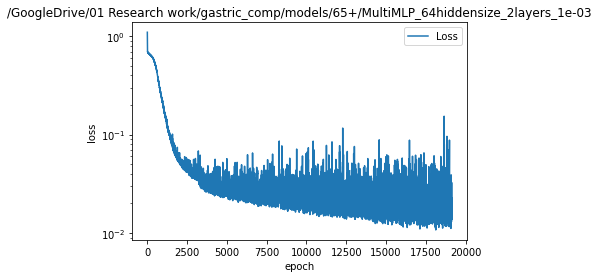

Drive/01 Research work/gastric_comp/models/65+/MultiMLP_64hiddensize_2layers_1e-03
-----------------------------------------------------------------------------
Train accuracy = 1.0000, Test accuracy = 0.5964
Train precision = 1.0000, Test precision = 0.6099
Train recall = 1.0000, Test recall = 0.5964
Train F1 score = 1.0000, Test F1 score = 0.6030
-------------------------------------------------------
Event: Mild; Train AUC = 1.0000, Test AUC = 0.5542
Event: Severe, death; Train AUC = 1.0000, Test AUC = 0.4324
Drive/01 Research work/gastric_comp/models/65+/MultiMLP_128hiddensize_1layers_1e-03
Epoch: 0, Loss: 1.1439e+00
Epoch: 100, Loss: 6.3821e-01
Epoch: 200, Loss: 5.9527e-01
Epoch: 300, Loss: 5.4535e-01
Epoch: 400, Loss: 4.9510e-01
Epoch: 500, Loss: 4.5622e-01
Epoch: 600, Loss: 4.1896e-01
Epoch: 700, Loss: 3.8248e-01
Epoch: 800, Loss: 3.5205e-01
Epoch: 900, Loss: 3.2242e-01
Epoch: 1000, Loss: 2.9722e-01
Epoch: 1100, Loss: 2.7168e-01
Epoch: 1200, Loss: 2.4948e-01
Epoch: 1300, Loss: 2

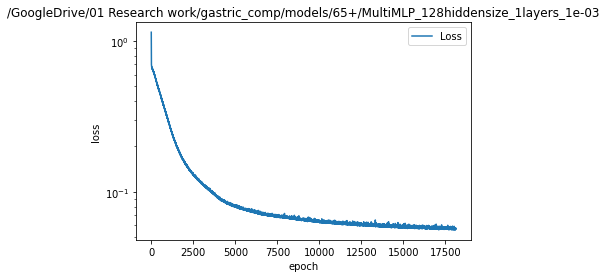

Drive/01 Research work/gastric_comp/models/65+/MultiMLP_128hiddensize_1layers_1e-03
-----------------------------------------------------------------------------
Train accuracy = 1.0000, Test accuracy = 0.6588
Train precision = 1.0000, Test precision = 0.6175
Train recall = 1.0000, Test recall = 0.6588
Train F1 score = 1.0000, Test F1 score = 0.6360
-------------------------------------------------------
Event: Mild; Train AUC = 1.0000, Test AUC = 0.5813
Event: Severe, death; Train AUC = 1.0000, Test AUC = 0.4529
Drive/01 Research work/gastric_comp/models/65+/MultiMLP_128hiddensize_2layers_1e-03
Epoch: 0, Loss: 1.0533e+00
Epoch: 100, Loss: 6.8102e-01
Epoch: 200, Loss: 6.6440e-01
Epoch: 300, Loss: 6.4529e-01
Epoch: 400, Loss: 6.2726e-01
Epoch: 500, Loss: 6.1000e-01
Epoch: 600, Loss: 5.9329e-01
Epoch: 700, Loss: 5.7292e-01
Epoch: 800, Loss: 5.4661e-01
Epoch: 900, Loss: 5.2496e-01
Epoch: 1000, Loss: 5.0501e-01
Epoch: 1100, Loss: 4.8134e-01
Epoch: 1200, Loss: 4.7270e-01
Epoch: 1300, Loss: 

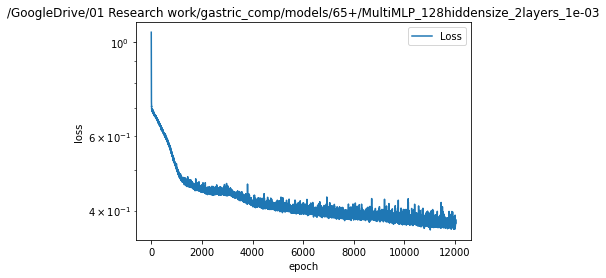

Drive/01 Research work/gastric_comp/models/65+/MultiMLP_128hiddensize_2layers_1e-03
-----------------------------------------------------------------------------
Train accuracy = 0.8368, Test accuracy = 0.6395
Train precision = 0.8270, Test precision = 0.6093
Train recall = 0.8368, Test recall = 0.6395
Train F1 score = 0.8239, Test F1 score = 0.6235
-------------------------------------------------------
Event: Mild; Train AUC = 0.9369, Test AUC = 0.5414
Event: Severe, death; Train AUC = 0.9466, Test AUC = 0.4734
Drive/01 Research work/gastric_comp/models/65+/MultiMLP_256hiddensize_1layers_1e-03
Epoch: 0, Loss: 9.9096e-01
Epoch: 100, Loss: 6.4442e-01
Epoch: 200, Loss: 5.9361e-01
Epoch: 300, Loss: 5.4319e-01
Epoch: 400, Loss: 4.9439e-01
Epoch: 500, Loss: 4.5666e-01
Epoch: 600, Loss: 4.1827e-01
Epoch: 700, Loss: 3.7970e-01
Epoch: 800, Loss: 3.5070e-01
Epoch: 900, Loss: 3.2694e-01
Epoch: 1000, Loss: 2.9749e-01
Epoch: 1100, Loss: 2.7366e-01
Epoch: 1200, Loss: 2.5393e-01
Epoch: 1300, Loss: 

Epoch: 24400, Loss: 5.3963e-02
Epoch: 24500, Loss: 5.4131e-02
Epoch: 24600, Loss: 5.3135e-02
Epoch: 24700, Loss: 5.2774e-02
Epoch: 24800, Loss: 5.2818e-02
Epoch: 24900, Loss: 5.3782e-02
Epoch: 25000, Loss: 5.2801e-02
Epoch: 25100, Loss: 5.3949e-02
Epoch: 25200, Loss: 5.2871e-02
Epoch: 25300, Loss: 5.3291e-02
Epoch: 25400, Loss: 5.2808e-02
Epoch: 25500, Loss: 5.3329e-02
Epoch: 25600, Loss: 5.2741e-02
Epoch: 25700, Loss: 5.2806e-02
Epoch: 25800, Loss: 5.2911e-02
Epoch: 25900, Loss: 5.2771e-02
Epoch: 26000, Loss: 5.2288e-02
Epoch: 26100, Loss: 5.3070e-02
Epoch: 26200, Loss: 5.4125e-02
Epoch: 26300, Loss: 5.2487e-02
Epoch: 26400, Loss: 5.2086e-02
Epoch: 26500, Loss: 5.3475e-02
Epoch: 26600, Loss: 5.2572e-02
Epoch: 26700, Loss: 5.1941e-02
Epoch: 26800, Loss: 5.2526e-02
Epoch: 26900, Loss: 5.3757e-02
Epoch: 27000, Loss: 5.2168e-02
Epoch: 27100, Loss: 5.2317e-02


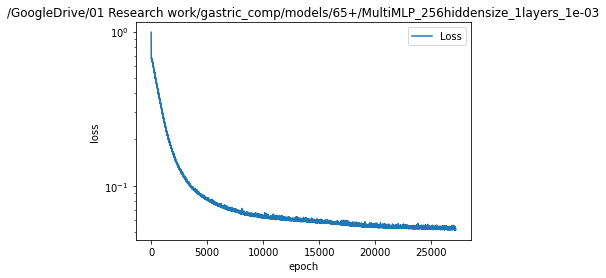

Drive/01 Research work/gastric_comp/models/65+/MultiMLP_256hiddensize_1layers_1e-03
-----------------------------------------------------------------------------
Train accuracy = 1.0000, Test accuracy = 0.6231
Train precision = 1.0000, Test precision = 0.6132
Train recall = 1.0000, Test recall = 0.6231
Train F1 score = 1.0000, Test F1 score = 0.6176
-------------------------------------------------------
Event: Mild; Train AUC = 1.0000, Test AUC = 0.5293
Event: Severe, death; Train AUC = 1.0000, Test AUC = 0.4502
Drive/01 Research work/gastric_comp/models/65+/MultiMLP_256hiddensize_2layers_1e-03
Epoch: 0, Loss: 9.9510e-01
Epoch: 100, Loss: 6.7864e-01
Epoch: 200, Loss: 6.7087e-01
Epoch: 300, Loss: 6.6783e-01
Epoch: 400, Loss: 6.4964e-01
Epoch: 500, Loss: 6.3203e-01
Epoch: 600, Loss: 6.2300e-01
Epoch: 700, Loss: 6.1881e-01
Epoch: 800, Loss: 6.1513e-01
Epoch: 900, Loss: 6.0650e-01
Epoch: 1000, Loss: 5.9317e-01
Epoch: 1100, Loss: 5.9152e-01
Epoch: 1200, Loss: 5.9255e-01
Epoch: 1300, Loss: 

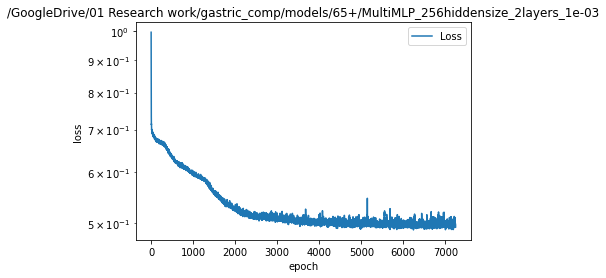

Drive/01 Research work/gastric_comp/models/65+/MultiMLP_256hiddensize_2layers_1e-03
-----------------------------------------------------------------------------
Train accuracy = 0.7805, Test accuracy = 0.6899
Train precision = 0.7270, Test precision = 0.5967
Train recall = 0.7805, Test recall = 0.6899
Train F1 score = 0.7268, Test F1 score = 0.6386
-------------------------------------------------------
Event: Mild; Train AUC = 0.9058, Test AUC = 0.5500
Event: Severe, death; Train AUC = 0.8011, Test AUC = 0.4592


In [47]:
criterion = nn.CrossEntropyLoss()

for weight_decay in [1e-3]:
    for hidden_size in [16, 32, 64, 128, 256]:
        for num_layer in [1, 2]:
            
            path = 'D:/GoogleDrive/01 Research work/gastric_comp/models/65+/MultiMLP_{}hiddensize_{}layers_{:.0e}'.format(hidden_size, num_layer, weight_decay)
            #if os.path.isfile(path):
            #    continue
            print(path[9:])

            model = MLP(input_size=stdX_train.shape[-1], hidden_size=hidden_size, num_layer=num_layer, num_event=num_event).to(device)
            if os.path.isfile(path):
                model.load_state_dict(torch.load(path, map_location = device))

            lr = 1e-3
            optimizer = adabound.AdaBound(model.parameters(), lr=lr, weight_decay=0)

            loss_array = []
            patience = 0
            min_loss = np.inf
            for e in range(int(1e6)):

                loss_array_tmp = []

                for stdX_train_batch, event_batch in train_loader:

                    total_batch = stdX_train_batch.float()
                    event_batch = event_batch.long()

                    y_pred = model(total_batch.to(device))

                    norm = 0.
                    for parameter in model.parameters():
                        norm += torch.norm(parameter, p=1)

                    loss1 = criterion(y_pred, event_batch.to(device))

                    loss = loss1 + weight_decay*norm
                    loss_array_tmp.append(loss1.item())

                    model.zero_grad()

                    loss.backward()

                    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
                    optimizer.step()

                loss_array.append(np.mean(loss_array_tmp))
                if e % 100 == 0:
                    print('Epoch: ' + str(e) + 
                          ', Loss: '+ f'{loss_array[-1]:.4e}')
                if min_loss > loss_array[-1]:
                    patience = 0
                    min_loss = loss_array[-1]
                    torch.save(model.state_dict(), path)
                else:
                    patience += 1

                torch.cuda.empty_cache()

                if patience > 1000:
                    break

            plt.plot(loss_array, label='Loss')
            plt.ylabel('loss')
            plt.xlabel('epoch')
            plt.yscale('log')
            plt.title(path[2:])
            plt.legend()
            plt.show()

            total_train_sort = torch.FloatTensor(stdX_train)
            total_test_sort = torch.FloatTensor(stdX_test)

            model.load_state_dict(torch.load(path, map_location = device))

            y_train = torch.softmax(model(total_train_sort.to(device)), 1).detach().cpu().numpy()
            y_test = torch.softmax(model(total_test_sort.to(device)), 1).detach().cpu().numpy()

            out_pred = np.where(y_train >= 0.5, 1, 0)
            acc_train = accuracy_score(event_train, out_pred.argmax(1))
            auc_train_mild = roc_auc_score(event_train == 1, y_train[:,1])
            auc_train_severedeath = roc_auc_score(event_train == 2, y_train[:,2])
            precision_train = precision_score(event_train, out_pred.argmax(1), average='weighted')
            recall_train = recall_score(event_train, out_pred.argmax(1), average='weighted')
            F1_train = f1_score(event_train, out_pred.argmax(1), average='weighted')
            
            out_pred = np.where(y_test >= 0.5, 1, 0)
            acc_test = accuracy_score(event_test, out_pred.argmax(1))
            auc_test_mild = roc_auc_score(event_test == 1, y_test[:,1])
            auc_test_severedeath = roc_auc_score(event_test == 2, y_test[:,2])
            precision_test = precision_score(event_test, out_pred.argmax(1), average='weighted')
            recall_test = recall_score(event_test, out_pred.argmax(1), average='weighted')
            F1_test = f1_score(event_test, out_pred.argmax(1), average='weighted')
            
            print('=====================================================================================')
            print(path[9:])
            print('-----------------------------------------------------------------------------')

            print('Train accuracy = {:.4f}, Test accuracy = {:.4f}'.format(acc_train, acc_test))
            print('Train precision = {:.4f}, Test precision = {:.4f}'.format(precision_train, precision_test))
            print('Train recall = {:.4f}, Test recall = {:.4f}'.format(recall_train, recall_test))
            print('Train F1 score = {:.4f}, Test F1 score = {:.4f}'.format(F1_train, F1_test))
            print('-------------------------------------------------------')

            print('Event: Mild; Train AUC = {:.4f}, Test AUC = {:.4f}'.format(auc_train_mild, auc_test_mild))
            print('Event: Severe, death; Train AUC = {:.4f}, Test AUC = {:.4f}'.format(auc_train_severedeath, auc_test_severedeath))
            print('=======================================================')